<b>Autonecoder tutorial:</b>
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html
</br>
<b>Deep Clustering with Convolutional Autoencoders paper:</b>
https://xifengguo.github.io/papers/ICONIP17-DCEC.pdf

In [651]:
# directory name of dataset
DATASET_NAME = "music_audio_benchmark"

# feature name (spectrogram, mel_spectrogram, chromagram)
FEATURE_NAME = "spectrogram"

# latent dim for ConvAE
# LATENT_DIM = [9, 32, 128, 512, 1024, 2048]
LATENT_DIM = [128, 1024]

# base channel size for ConvAE
# BASE_CHANNEL_SIZE = [32, 64, 128, 256, 512]
BASE_CHANNEL_SIZE = 32

# epochs for ConvAE pretraining
EPOCHS_AE = 450
# epochs for DCEC training
# EPOCHS_DCEC = 10_000

In [652]:
import os
import re
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

from torch.utils.data import Dataset

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import torchvision
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

# Import from file (fix num_workers problem)
from FeaturesDataset import FeaturesDataset
from FeaturesDataset import load_img
from FeaturesDataset import WIDTH
from FeaturesDataset import HEIGHT

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Properly utilize Tensor Cores
torch.set_float32_matmul_precision("high")

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

CHECKPOINT_PATH = os.path.join("..", 'checkpoints')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Seed set to 42


Device: cuda:0


In [653]:
checkpoints_path = f"{CHECKPOINT_PATH}/{DATASET_NAME}"
if not os.path.exists(checkpoints_path):
    print("CREATING CHECKPOINT FOLDER FOR MODELS")
    os.makedirs(checkpoints_path)

## Load data

In [654]:
def load_numpy_array(path):
    return np.load(path)

def get_first_n_images(dataset, n):
    return torch.stack([dataset[i][0] for i in range(n)], dim=0)

### Path to images

In [655]:
project_dir = os.path.relpath(os.path.join(os.getcwd(), os.pardir))
features_dir = os.path.join(project_dir, "features")

#TODO: argument for dataset folder name
dataset_dir = os.path.join(features_dir, DATASET_NAME)

csv_file_name = "features.csv"
csv_file_path = os.path.join(dataset_dir, csv_file_name)

df = pd.read_csv(csv_file_path)
path_columns = [
    'name', 'label',
    'path_spectrogram_arr', 'path_mel_spectrogram_arr', 'path_chromagram_arr', 'path_mfccs_arr', 'path_mfccs_without_0_arr', 
    'path_spectrogram_img',  'path_mel_spectrogram_img', 'path_chromagram_img', 'path_mfccs_img', 'path_mfccs_without_0_img' 
]

df_paths = df[path_columns].copy()
feature = f'path_{FEATURE_NAME}_img'

features_paths = df_paths[feature].values
labels = df['label'].tolist()

# convert labels to numerical data
unique_labels = list(set(labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

numerical_targets = [label_to_index[label] for label in labels]

# convert numerical labels to tensor
labels_tensor = torch.tensor(numerical_targets, dtype=torch.long)

In [656]:
NUM_UNIQUE_LABELS = len(unique_labels)

label_encoder = LabelEncoder()
ORIGINAL_LABELS = label_encoder.fit_transform(df['label'])

CLUSTER_NAMES = df['label'].unique()

In [657]:
print(f"WIDTH: {WIDTH}")
print(f"HEIGHT: {HEIGHT}")

WIDTH: 96
HEIGHT: 48


### Train and validation datasets

In [658]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

feature_dataset = FeaturesDataset(features_paths, labels_tensor, transform=transform)

train_length = int(0.8 * len(feature_dataset))
val_length = len(feature_dataset) - train_length
train_set, val_set = torch.utils.data.random_split(feature_dataset, [train_length, val_length])

train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True, pin_memory=True, num_workers=8, persistent_workers=True)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=True, num_workers=8, persistent_workers=True)

### Validate if images are correctly loaded

In [659]:
def compare_imgs(img1, img2, title=""):
    loss = F.mse_loss(img1, img2, reduction="sum")
    
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True, value_range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    
    plt.figure(figsize=(12, 6))
    plt.title(f"{title}, Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

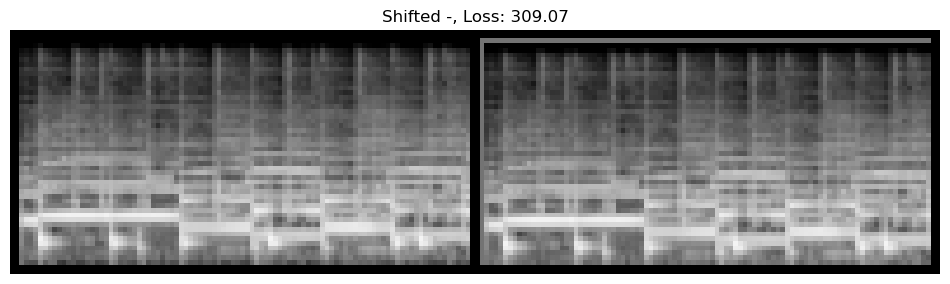

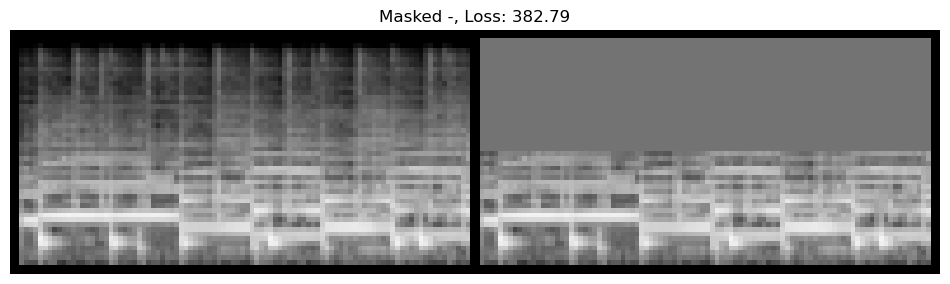

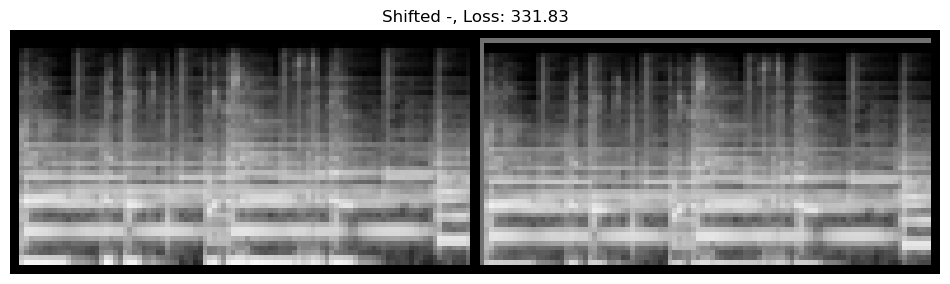

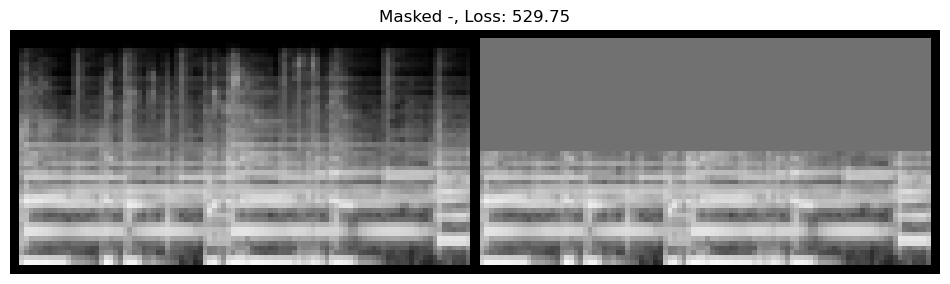

In [660]:
for i in range(2):
    # Load example image
    img, _ = feature_dataset[i]
    img_mean = img.mean(dim=[1, 2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

## Autoencoder

In [661]:
class Encoder(nn.Module):
    """
    Inputs: 
        - num_input_channels : Number of input channels of the image.
        - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
        - latent_dim : Dimensionality of latent representation z
        - activation_fn : Activation function used throughout the encoder network
        - width : Image width.
        - height : Image height.
    """
    def __init__(
        self,
        num_input_channels: int,
        base_channel_size: int,
        latent_dim: int,
        width: int,
        height: int,
        activation_fn: object = nn.GELU
    ): 

        super().__init__()
        self.width = width
        self.height = height
        
        if width == height:
            dynamic_padding = 0
        else:
            dynamic_padding = 1
        
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=num_input_channels, out_channels=base_channel_size, kernel_size=5, stride=2, padding=2
            ),  # 28x28 -> 14x14
            activation_fn(),
            
            nn.Conv2d(
                in_channels=base_channel_size, out_channels=2 * base_channel_size, kernel_size=5, stride=2, padding=2
            ),  # 14x14 -> 7x7
            activation_fn(),
            
            nn.Conv2d(
                in_channels=2 * base_channel_size, out_channels=4 * base_channel_size, kernel_size=3, stride=2, padding=dynamic_padding
            ),  # 7x7 -> 3x3
            activation_fn(),
            
            nn.Flatten(),
            nn.Linear(in_features=4 * base_channel_size * (width // 8) * (height // 8), out_features=latent_dim),
            activation_fn()
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [662]:
class Decoder(nn.Module):
    """
    Inputs: 
        - num_input_channels : Number of input channels of the image.
        - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
        - latent_dim : Dimensionality of latent representation z
        - activation_fn : Activation function used throughout the encoder network
        - width : Image width.
        - height : Image height.
    """
    def __init__(
        self,
        num_input_channels: int,
        base_channel_size: int,
        latent_dim: int,
        width: int,
        height: int,
        activation_fn: object = nn.GELU
    ): 

        super().__init__()
        self.width = width
        self.height = height

        print(f"WIDTH: {width}")
        print(f"HEIGHT: {height}")
        if width == height:
            dynamic_padding = 0
            dynamic_output_padding = 0
        else:
            dynamic_padding = 1
            dynamic_output_padding = 1
            
        
        self.linear = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=4 * base_channel_size * (width // 8) * (height // 8)),
        )
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=4 * base_channel_size, 
                out_channels=2 * base_channel_size, 
                kernel_size=3, 
                stride=2, 
                padding=dynamic_padding,
                output_padding=dynamic_output_padding
            ),  # 3x3 -> 7x7
            activation_fn(),
            
            nn.ConvTranspose2d(
                in_channels=2 * base_channel_size, 
                out_channels=base_channel_size, 
                kernel_size=5,
                stride=2, 
                padding=2,
                output_padding=1
            ),  # 7x7 -> 14x14
            activation_fn(),
            
            nn.ConvTranspose2d(
                in_channels=base_channel_size, 
                out_channels=num_input_channels, 
                kernel_size=5, 
                stride=2, 
                padding=2,
                output_padding=1
            ) # 14x14 -> 28x28
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, (self.height // 8), (self.width // 8)) # reshape tensor (spatial dimensions set to 16x8)
        x = self.net(x)
        return x

In [663]:
class Autoencoder(pl.LightningModule):
    """
    Inputs: 
        - base_channel_size : Number of channels used in the first convolutional layers. Deeper layers might use a duplicate of it.
        - latent_dim : Dimensionality of latent representation z
        - encoder_class : Encoder
        - decoder_class : Decoder
        - num_input_channels : Number of input channels of the image. (RGB - 3, GRAY - 1)
        - width : Image width. Must be divisable by 4.
        - height : Image height. Must be divisable by 4.
    """
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        width: int = 28,
        height: int = 28
    ):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Save hyperparameters
        self.save_hyperparameters()
        
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim, width, height)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim, width, height)
        
        # Example input array needed for visualizing the graph of network
#         self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        self.example_input_array = torch.zeros(1, num_input_channels, width, height)
        
        
    """
    The forward function takes in an image and returns the reconstructed image
    """
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    """
    Given a batch of images, this function returns the reconstruction loss (MSE in our case)
    """
    def _get_recontruction_loss(self, batch):
        x, _ = batch
        decoded = self.forward(x)
        
        if x.shape != decoded.shape:
            raise ValueError(f"Shapes of x and x_hat do not match: {x.shape} vs {decoded.shape}")
        
        loss = F.mse_loss(x, decoded, reduction="sum")
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.2,
            patience=20,
            min_lr=5e-5
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss"
        }
    
    def training_step(self, batch, batch_idx):
        loss = self._get_recontruction_loss(batch)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_recontruction_loss(batch)
        self.log('val_loss', loss)
        
    def test_step(self, batch, batch_idx):
        loss = self._get_recontruction_loss(batch)
        self.log('test_loss', loss)

In [664]:
autoencoder_arch = Autoencoder(num_input_channels=1, base_channel_size=32, latent_dim=10, width=28, height=28)
print(autoencoder_arch)

WIDTH: 28
HEIGHT: 28
Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): GELU(approximate='none')
      (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (3): GELU(approximate='none')
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      (5): GELU(approximate='none')
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=1152, out_features=10, bias=True)
      (8): GELU(approximate='none')
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=10, out_features=1152, bias=True)
    )
    (net): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): GELU(approximate='none')
      (2): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
      (3): GELU(approximate='none')
      (4): ConvTranspose2d(32, 1, kernel_size=(5, 5

In [665]:
class GenerateCallback(pl.Callback):
    def __init__(self, imgs, every_n_epochs=5):
        super().__init__()
        self.imgs = imgs # Images to reconstruct
        self.every_n_epochs = every_n_epochs
        
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            imgs = self.imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                
                if isinstance(pl_module, DCEC):
                    _, reconst_imgs, _ = pl_module(imgs)
                else:
                    reconst_imgs = pl_module(imgs)

                    pl_module.train()
            
            images = torch.stack([imgs, reconst_imgs], dim=1).flatten(0, 1)
            grid = torchvision.utils.make_grid(images, nrow=2, normalize=True, value_range=(-1, 1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

In [669]:
def get_embeddings(model, data_loader, device):
    model.eval()
    embeddings = []
    labels = []
    model.to(device)
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            # Get embeddings from encoder
            z = model.encoder(images)
            
            embeddings.append(z.cpu().numpy())
            labels.append(targets.cpu().numpy())
    
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    
    return embeddings, labels


def get_model_checkpoint(pretrained_dir, model_name, dir_name):
    if model_name == "DCEC":
        checkpoint = ModelCheckpoint(
            monitor="val_total_loss",
            mode="min",
            save_top_k=1,
            save_weights_only=True,
            dirpath=f"{pretrained_dir}/{dir_name}",
            filename="{epoch:02d}-{val_total_loss:.2f}"
        )
    else:
        checkpoint = ModelCheckpoint(
            monitor="val_loss",
            mode="min",
            save_top_k=1,
            save_weights_only=True,
            dirpath=f"{pretrained_dir}/{dir_name}",
            filename="{epoch:02d}-{val_loss:.2f}"
        )
        
    return checkpoint


def extract_loss(filename):
    match = re.search(r'val_[a-zA-Z_]*loss=(\d+\.\d+)', filename)
    return float(match.group(1)) if match else float('inf')


def get_checkpoint_file(path, descriptors, descriptors_n_clusters="", descriptor_feature=FEATURE_NAME):
    # Create dir if it does not exist
    if not os.path.exists(path):
        os.makedirs(path)
        
    if descriptors_n_clusters:
        descriptors_n_clusters = "-n_clu-" + str(descriptors_n_clusters)
    
    target_pattern = f"{descriptor_feature}-{descriptors}{descriptors_n_clusters}"
    subfolders = [
        folder for folder 
        in os.listdir(path) 
        if target_pattern == folder
    ]
    print(subfolders)
    # If there are no checkpoints in path return None
    if not subfolders:
        return None

    checkpoint_folder = os.path.join(path, subfolders[0])
    ckpt_files = [file for file in os.listdir(checkpoint_folder) if file.endswith('.ckpt')]
    if not ckpt_files:
        print("No checkpoint files found.")
        return None

    # If there is only one file, no need to sort, just check it
    if len(ckpt_files) == 1:
        if extract_loss(ckpt_files[0]) != float('inf'):
            print(f"Best checkpoint (only one file): {ckpt_files[0]}")
            return os.path.join(checkpoint_folder, ckpt_files[0])
        else:
            print("No valid checkpoint file found.")
            return None

    # Sort the files by extracted loss value
    ckpt_files.sort(key=extract_loss)
    
    if ckpt_files and extract_loss(ckpt_files[0]) != float('inf'):
        print(f"Best checkpoint: {ckpt_files[0]}")
        return os.path.join(checkpoint_folder, ckpt_files[0])
    else:
        print("No valid checkpoint files found.")
        return None

### Train models

#### Step 1: Pretrain autoencoder

In [674]:
def train_ae(train_loader, val_loader, latent_dim=10, base_channel_size=32, width=28, height=28, dataset_name=DATASET_NAME, feature_name=FEATURE_NAME):
    pretrained_dir = os.path.join(CHECKPOINT_PATH, dataset_name, "autoencoder")
    
    print(feature_name)
    checkpoint_callback = get_model_checkpoint(pretrained_dir, "autoencoder", f"{feature_name}-{latent_dim}-{base_channel_size}")
    
    trainer = pl.Trainer(
        default_root_dir=os.path.join("..", "logs"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=EPOCHS_AE,
        callbacks=[
            checkpoint_callback,
#             GenerateCallback(get_first_n_images(feature_dataset, 4), every_n_epochs=10),
            LearningRateMonitor("epoch")
        ],
        log_every_n_steps=20
    )
    
    trainer.logger._log_graph = True 
    trainer.logger._default_hp_metric = None 
    
    checkpoint_file = get_checkpoint_file(pretrained_dir, f"{latent_dim}-{base_channel_size}", descriptor_feature=feature_name)
    if os.path.isdir(pretrained_dir) and checkpoint_file is not None:
        print("FOUND PRETRAINED AUTOENCODER!")
        model = Autoencoder.load_from_checkpoint(checkpoint_file)
    else:
        print("TRAINING AUTOENCODER...")
        model = Autoencoder(base_channel_size=base_channel_size, latent_dim=latent_dim, width=width, height=height)
        
        trainer.fit(model, train_loader, val_loader)
    
        best_model_path = checkpoint_callback.best_model_path
        model = Autoencoder.load_from_checkpoint(best_model_path)
    
    val_result = trainer.test(model, val_loader, verbose=False)
    result = {"val": val_result}
    
    return model, result

In [675]:
# print("STEP 1: PRETRAIN AUTOENCODER")
model_dict = {}
for latent in LATENT_DIM:
    model_id, result_id = train_ae(
        train_loader=train_loader, 
        val_loader=val_loader, 
        latent_dim=latent,
        base_channel_size=BASE_CHANNEL_SIZE,
        width=WIDTH,
        height=HEIGHT
    )

    model_dict[latent] = {
        "model": model_id,
        "result": result_id
    }

spectrogram


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[]
TRAINING AUTOENCODER...
WIDTH: 96
HEIGHT: 48


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 1.3 M  | [1, 1, 96, 48] | [1, 128]      
1 | decoder | Decoder | 1.3 M  | [1, 128]       | [1, 1, 48, 96]
----------------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.482    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=450` reached.


WIDTH: 96
HEIGHT: 48


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

spectrogram


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


['spectrogram-1024-32']
Best checkpoint (only one file): epoch=55-val_loss=10888.78.ckpt
FOUND PRETRAINED AUTOENCODER!
WIDTH: 96
HEIGHT: 48


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

##### Check autoencoder scores

In [747]:
for latent_dim in model_dict:
    print(f"latent_dim: {latent_dim}")
    print(model_dict[latent_dim]["result"])

latent_dim: 128
{'val': [{'test_loss': 5660.50048828125}]}
latent_dim: 1024
{'val': [{'test_loss': 5513.71875}]}


In [748]:
def save_plot(fig, filename, directory=os.path.join('..', 'results', DATASET_NAME)):
    if directory:
        os.makedirs(directory, exist_ok=True)
        filepath = os.path.join(directory, filename)
    else:
        filepath = filename
        
    fig.savefig(filepath, bbox_inches='tight')
    print(f"Plot saved as {filepath}")

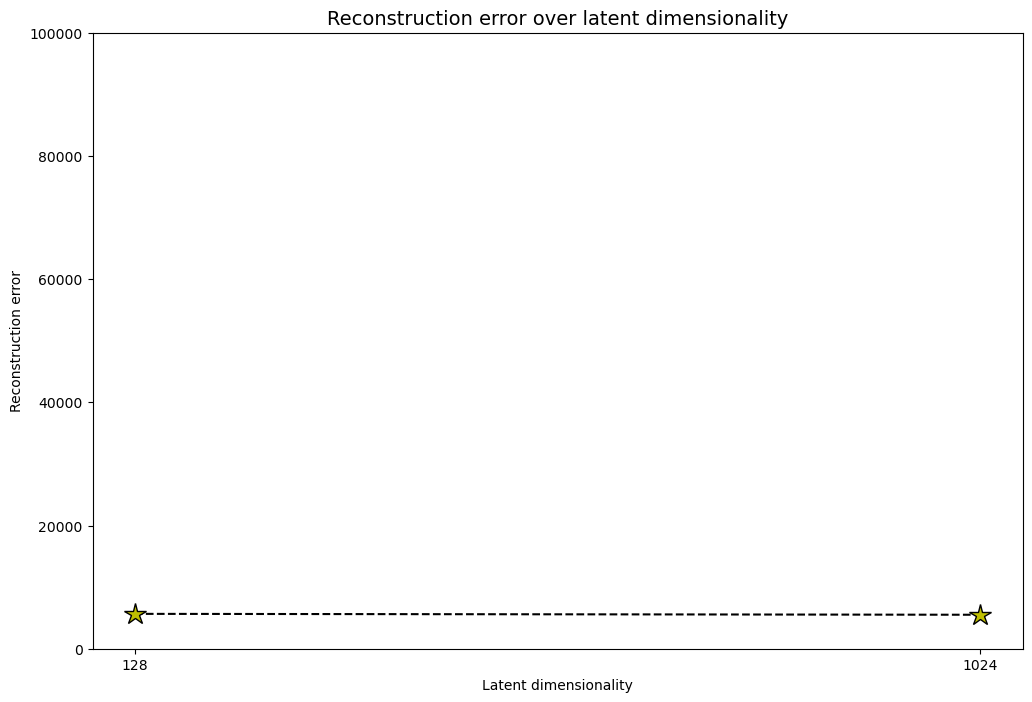

Plot saved as ..\results\music_audio_benchmark\reconstruction_error_plot_spectrogram.png


In [749]:
latent_dims = sorted([model for model in model_dict])
val_scores = [model_dict[latent_dim]["result"]["val"][0]["test_loss"] for latent_dim in latent_dims]

fig = plt.figure(figsize=(12, 8))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0, 100_000)
plt.show()

save_plot(fig, f"reconstruction_error_plot_{FEATURE_NAME}.png")

##### Visualise autoencoder image reconstructions

In [750]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    fig = plt.figure(figsize=(12 , 8))
    plt.title(f"Reconstructed from {model.hparams.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()
    
    save_plot(fig, f"image_reconstruction_{model.hparams.latent_dim}_{FEATURE_NAME}")

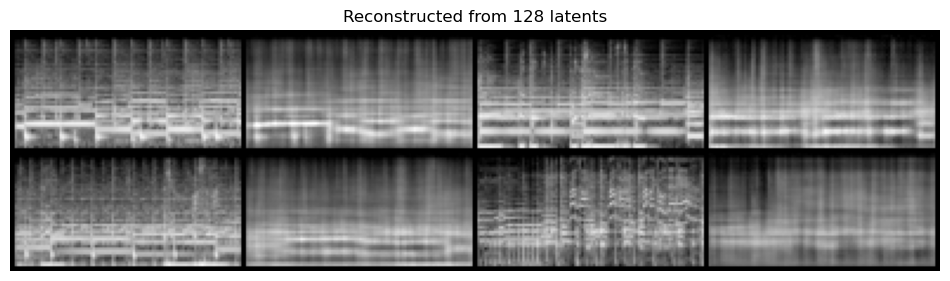

Plot saved as ..\results\music_audio_benchmark\image_reconstruction_128_spectrogram


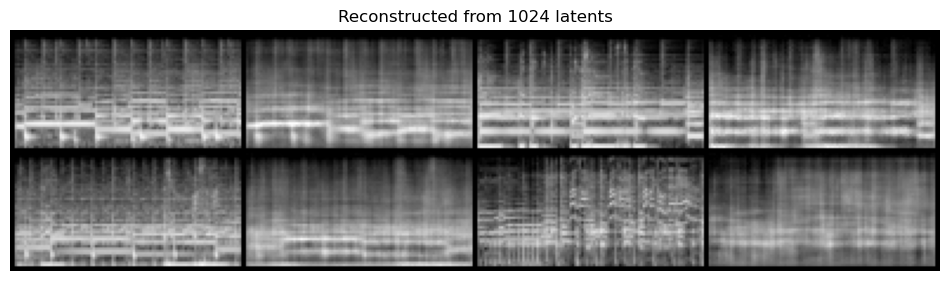

Plot saved as ..\results\music_audio_benchmark\image_reconstruction_1024_spectrogram


In [751]:
input_imgs = get_first_n_images(feature_dataset, 4)
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs)

In [752]:
def get_best_model(model_dict, loss_name):
    best_model = None
    best_score = np.inf

    for latent_dim in model_dict:
        score = model_dict[latent_dim]["result"]['val'][0][loss_name]
        if score < best_score:
            best_score = score
            best_model = model_dict[latent_dim]["model"]
            
    return best_model, best_score

best_model, best_score = get_best_model(model_dict, 'test_loss')
        
print(f"Best trained model: {best_model.latent_dim}, loss: {best_score}")

Best trained model: 1024, loss: 5513.71875


### Embed images and show most similar ones

In [753]:
def embed_imgs(model, data_loader):
    img_list = [] 
    embed_list = []
    
    model.eval()
    
    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        
        imgs = imgs.to(model.device)
        
        img_list.append(imgs)
        embed_list.append(z)
    
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))

In [754]:
train_img_embeds = embed_imgs(best_model, train_loader)
val_img_embeds = embed_imgs(best_model, val_loader)

Encoding images:   0%|          | 0/23 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/5 [00:00<?, ?it/s]

In [755]:
def find_similiar_images(query_img, query_z, key_embeds, k=4):
    device = key_embeds[1].device
    query_z = query_z.to(device)
    query_img = query_img.to(device)
    
    dist = torch.cdist(query_z[None, :], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    
    indices = indices.to(device)
    
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:k]]], dim=0)
    imgs_to_display = imgs_to_display.cpu()
    
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=k + 1, normalize=True, value_range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    
    plt.figure(figsize=(12, 3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

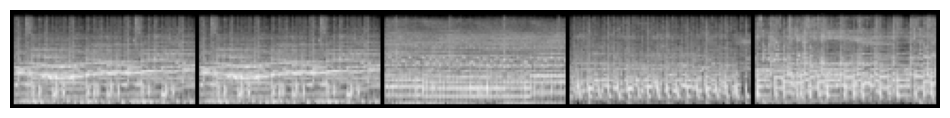

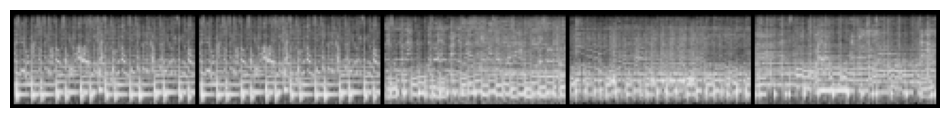

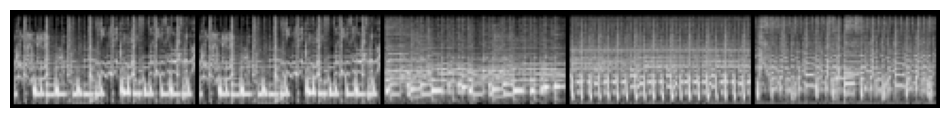

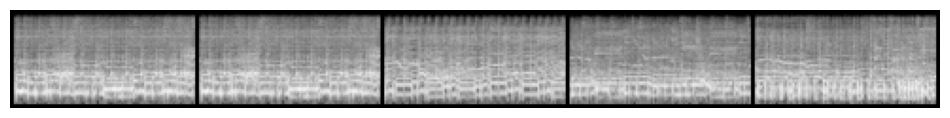

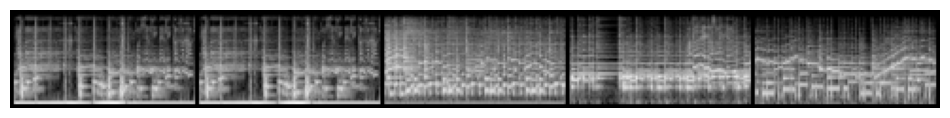

In [756]:
for i in range(5):
    find_similiar_images(val_img_embeds[0][i + 50], val_img_embeds[1][i + 50], key_embeds=val_img_embeds)

#### Get embeddings from encoder with labels

In [757]:
def get_all_embeddings_labels(model, train_loader, val_loader, device):
    train_embeddings, train_true_labels = get_embeddings(model, train_loader, device)
    val_embeddings, val_true_labels = get_embeddings(model, val_loader, device)

    all_embeddings = np.concatenate((train_embeddings, val_embeddings), axis=0)
    all_labels = np.concatenate((train_true_labels, val_true_labels), axis=0)

    return all_embeddings, all_labels

In [775]:
# Embeddings and labels for model with 128 latent_dim
all_embeddings, all_labels = get_all_embeddings_labels(
    model_dict[128]["model"], 
    train_loader, 
    val_loader, 
    device
)

# Embeddings and labels for model with 1024 latent_dim
all_embeddings_1024, all_labels_1024 = get_all_embeddings_labels(
    model_dict[1024]["model"], 
    train_loader, 
    val_loader, 
    device
)

# df for future visualisations
df_to_vis_1024 = execute_pca(all_embeddings_1024, 2)

Sum of Explained Variance: 0.160374965518713


#### Visualise embeddings

In [776]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import mode
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment

In [777]:
# def visualise_clustering(embeddings, num_clusters, labels, title=""):
#     pca = PCA(n_components=2)
#     embeddings_pca = pca.fit_transform(embeddings)

#     # Plotting the clusters
#     plt.figure(figsize=(8, 6))
#     plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels, cmap='magma', s=num_clusters)
#     plt.colorbar()
#     plt.title(f'K-means Clustering of Embeddings {title}')
#     plt.xlabel('PCA Feature 1')
#     plt.ylabel('PCA Feature 2')
#     plt.show()
    

def execute_pca(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(embeddings)

    explained_variance = pca.explained_variance_ratio_
    print("Sum of Explained Variance:", sum(explained_variance))
    
    pca_embeddings = pca.transform(embeddings)
    pca_columns = [f'PCA_{i + 1}' for i in range(n_components)]
    pca_df = pd.DataFrame(data=pca_embeddings, columns=pca_columns)
    return pca_df
    
    
def visualise_clusters(ax, labels, title, df, colors=None, cluster_names=None):
    pca_to_visualise_df = df[["PCA_1", "PCA_2"]]
    
    unique_labels = set(labels)
#     print(unique_labels)
    
    if colors is None:
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels) + 1)]
#     print(colors)
#     print("")
        
    if cluster_names is not None and len(cluster_names) == len(unique_labels):
        label_mapping = dict(zip(unique_labels, cluster_names))
    else:
        label_mapping = {k: f'Cluster {k}' for k in unique_labels}
    
    for k in unique_labels:
        class_member_mask = (labels == k)

        xy = pca_to_visualise_df[class_member_mask]
        ax.plot(
            xy['PCA_1'], 
            xy['PCA_2'], 
            'o', 
            markerfacecolor=tuple(colors[k]),
            markeredgecolor='k', 
            markeredgewidth=0.8,
            markersize=10,
            alpha=0.8,
            label=label_mapping[k]
        )

    ax.set_title(f'{title} clustering')
    ax.set_xlabel('PCA Feature 1')
    ax.set_ylabel('PCA Feature 2')
    
#     ax.set_xlim(-10, 10)
#     ax.set_ylim(-10, 10)
    
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

Sum of Explained Variance: 0.25950850918889046


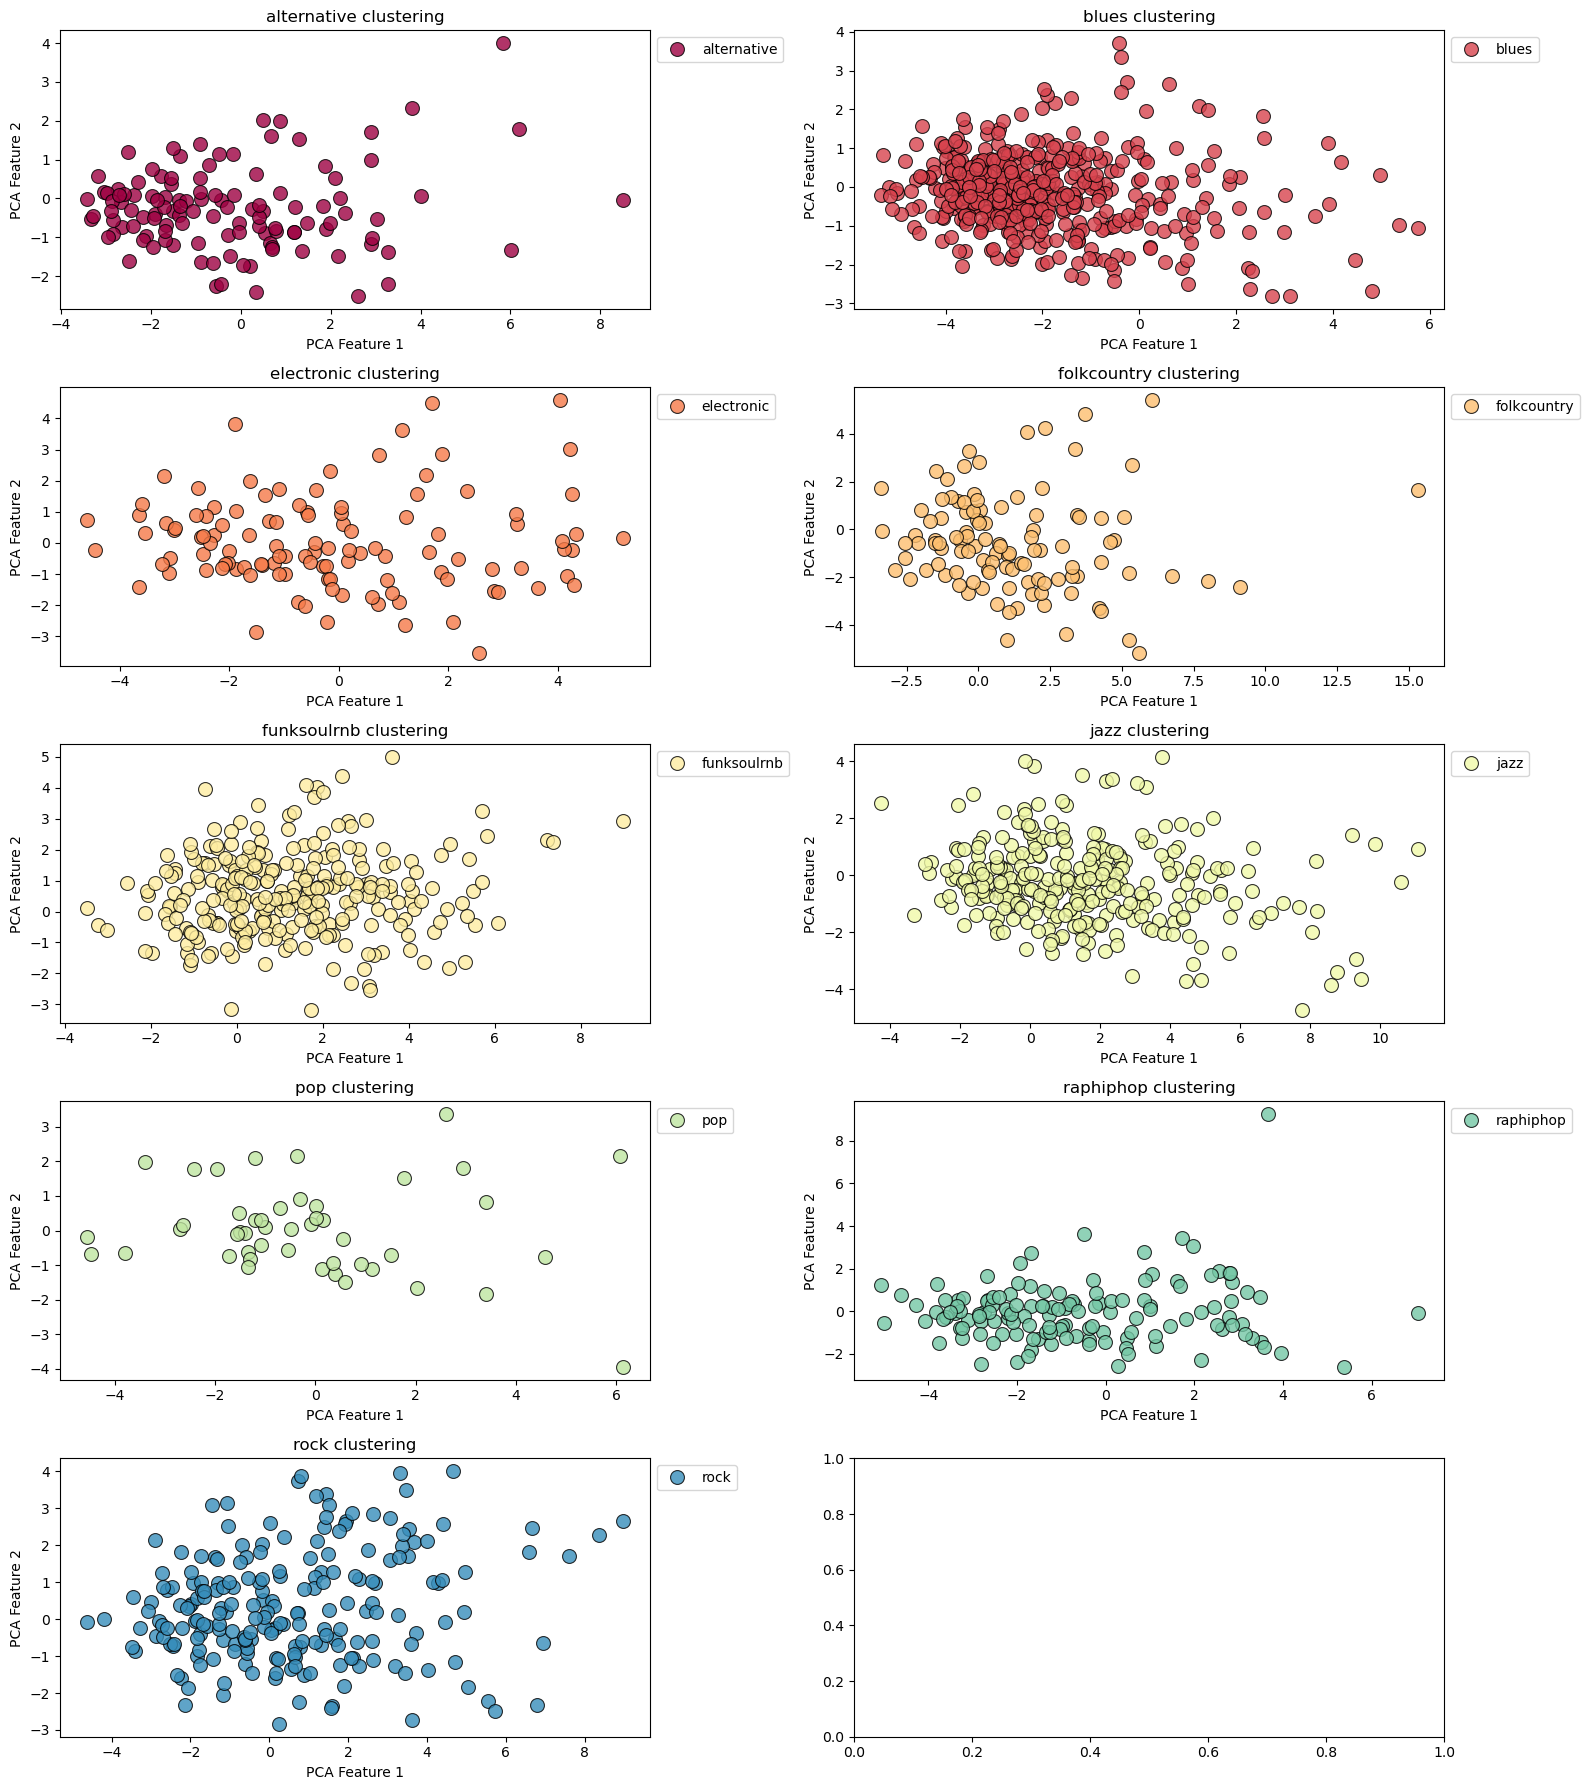

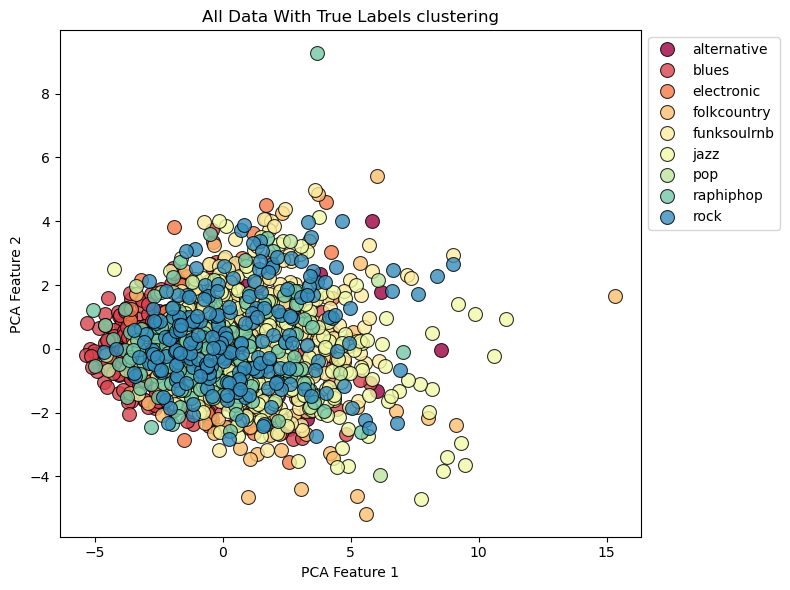

In [778]:
df_to_vis = execute_pca(all_embeddings, 2)

str_labels = np.array([unique_labels[label] for label in all_labels])
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels) + 1)]

# check if column named label exist in df
if 'label' in df.columns:
    fig, axes = plt.subplots((NUM_UNIQUE_LABELS // 2) + 1, 2, figsize=(16, 18))

    for n, cluster_name in enumerate(CLUSTER_NAMES):
        row_idx = n // 2
        col_idx = n % 2
        
        cluster_mask = (all_labels == n)
        cluster_labels = all_labels[cluster_mask]
        cluster_df = df_to_vis[cluster_mask]
        visualise_clusters(axes[row_idx, col_idx], cluster_labels, cluster_name, cluster_df, colors=colors, cluster_names=[cluster_name])
    
    fig.tight_layout()
    plt.show()
    
    
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))
    
    visualise_clusters(axes, all_labels, 'All Data With True Labels', df_to_vis, colors=colors, cluster_names=CLUSTER_NAMES)
    
    fig.tight_layout()
    plt.show()   

#### Estimate number of clusters

In [779]:
def silhouette_analysis(X, max_clusters, estimator, estimator_params={}):
    range_n_clusters =  list(range(2, max_clusters + 1))
    
    scores = {}
    
    for n_clusters in range_n_clusters:
        clusterer = estimator(n_clusters=n_clusters, **estimator_params)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(f'For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg}')
        scores[n_clusters] = silhouette_avg
        
    return scores

In [780]:
params = {
    'n_init': 'auto',
    'random_state': 23,
}
scores = silhouette_analysis(all_embeddings, 15, KMeans, params)

sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
top_3_n_clusters = [num_clusters for num_clusters, _ in sorted_scores[:3]]

chosen_clusters = top_3_n_clusters + [NUM_UNIQUE_LABELS]
print(f"chosen clusters: {chosen_clusters}")

For n_clusters = 2, The average silhouette_score is : 0.1642676144838333
For n_clusters = 3, The average silhouette_score is : 0.0723368301987648
For n_clusters = 4, The average silhouette_score is : 0.06260570138692856
For n_clusters = 5, The average silhouette_score is : 0.026507526636123657
For n_clusters = 6, The average silhouette_score is : 0.014464570209383965
For n_clusters = 7, The average silhouette_score is : 0.012066015042364597
For n_clusters = 8, The average silhouette_score is : 0.012494773603975773
For n_clusters = 9, The average silhouette_score is : 0.008016156032681465
For n_clusters = 10, The average silhouette_score is : 0.008502823300659657
For n_clusters = 11, The average silhouette_score is : 0.008800933137536049
For n_clusters = 12, The average silhouette_score is : -0.0007430892437696457
For n_clusters = 13, The average silhouette_score is : -0.004388024564832449
For n_clusters = 14, The average silhouette_score is : -0.008755012415349483
For n_clusters = 15, 

#### Cluster

In [785]:
# Perform K-means clustering
def cluster_kmeans(latent_dim, embeddings, chosen_clusters, df_to_vis):
    all_predicted_labels = {}
#     all_embeddings = models_embeddings[latent_dim]['embeddings']
    
    for cluster in chosen_clusters:
        kmeans = KMeans(n_clusters=cluster, random_state=23, n_init='auto', init='k-means++')
        predicted_labels = kmeans.fit_predict(embeddings)

        all_predicted_labels[cluster] = predicted_labels
        
        # Visualise 
        fig, axes = plt.subplots(1, 1, figsize=(8, 4))
        visualise_clusters(axes, predicted_labels, f'AE {cluster} clusters, {FEATURE_NAME}, {latent_dim} latent predicted', df_to_vis)
        fig.tight_layout()
        plt.show()
    
    return all_predicted_labels

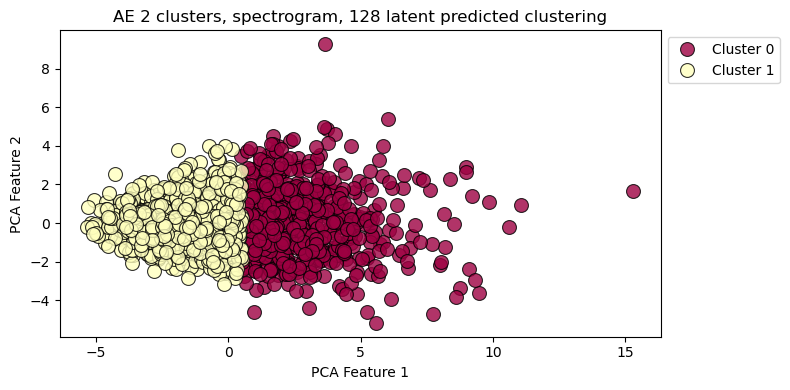

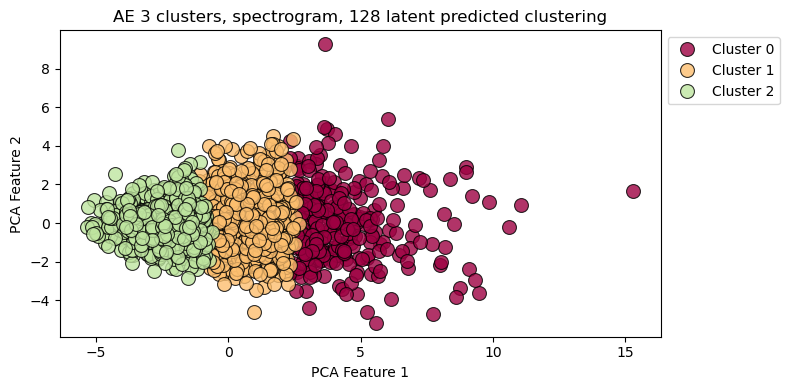

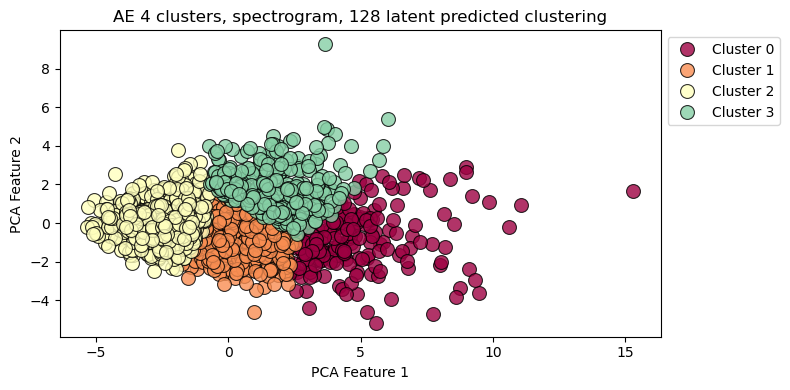

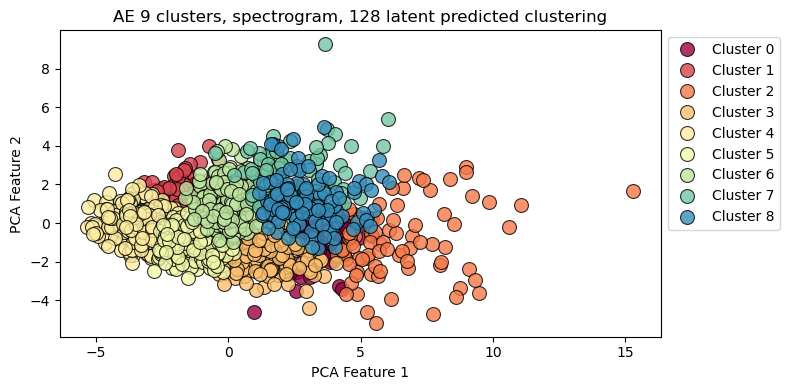

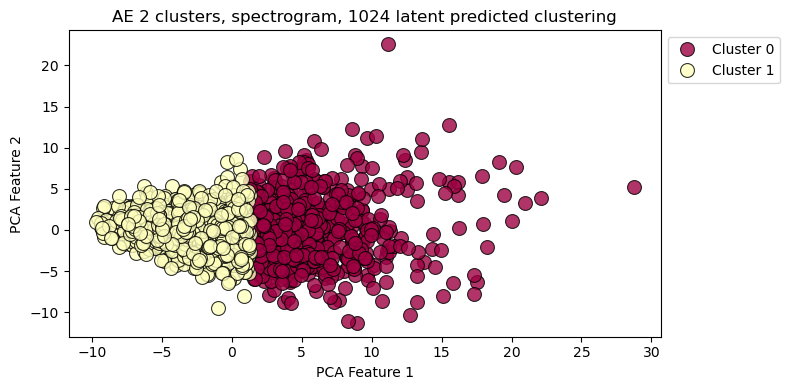

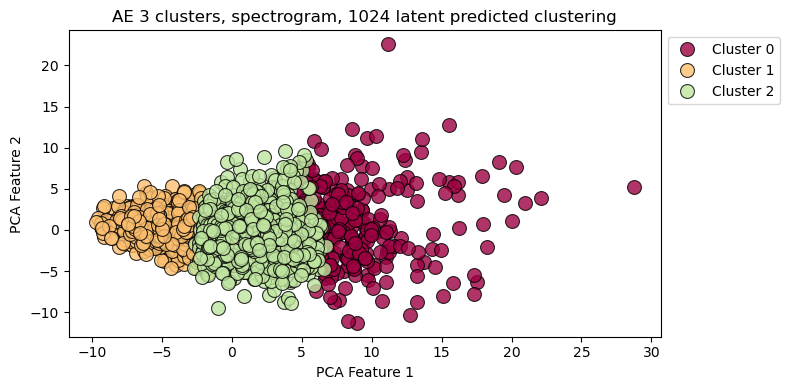

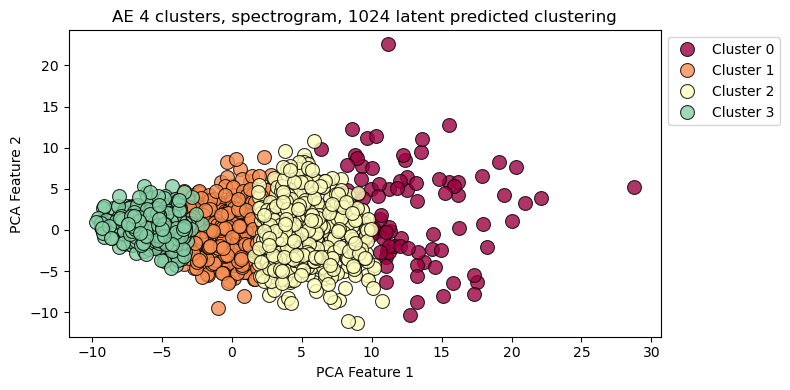

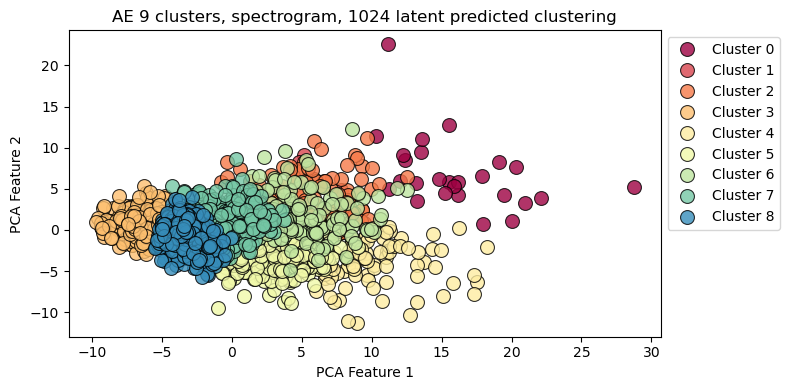

In [786]:
# Cluster data using kmeans on embedded data (laten_dim 128)
all_predicted_labels[128] = cluster_kmeans(128, all_embeddings, chosen_clusters, df_to_vis)

# Cluster data using kmeans on embedded data (laten_dim 1024)
all_predicted_labels[1024] = cluster_kmeans(1024, all_embeddings_1024, chosen_clusters, df_to_vis_1024)

### Evaluate clustering

In [787]:
def compute_cluster_purity(true_labels, predicted_labels, num_true_clusters, num_predicted_clusters):
    purity_matrix = np.zeros((num_true_clusters, num_predicted_clusters))

    for i in range(num_predicted_clusters):
        cluster_indices = np.where(predicted_labels == i)[0]
        
        # Skip if there is no data points in cluster i
        if len(cluster_indices) == 0:
            continue
        
        cluster_true_labels = true_labels[cluster_indices]
        unique_true_labels, counts = np.unique(cluster_true_labels, return_counts=True)
        most_frequent_true_label = unique_true_labels[np.argmax(counts)]
        purity_matrix[most_frequent_true_label, i] = counts.max() / len(cluster_indices)

    return purity_matrix


def assign_clusters(true_labels, predicted_labels, num_true_clusters, num_predicted_clusters):
    purity_matrix = compute_cluster_purity(true_labels, predicted_labels, num_true_clusters, num_predicted_clusters)
    row_ind, col_ind = linear_sum_assignment(-purity_matrix)  # maximize the sum of purities

    cluster_mapping = {}
    for i, j in zip(row_ind, col_ind):
        cluster_mapping[j] = i

    return cluster_mapping


def map_clusters(predicted_labels, cluster_mapping):
    mapped_labels = np.zeros(len(predicted_labels))
    for predicted_cluster, true_cluster in cluster_mapping.items():
        mapped_labels[predicted_labels == predicted_cluster] = true_cluster
    return mapped_labels.astype(int)

In [788]:
def calculate_nmif(output_labels, original_labels):
    return normalized_mutual_info_score(output_labels, original_labels)

def calculate_acc(output_labels, original_labels):
    cluster_mapping = assign_clusters(original_labels, output_labels, NUM_UNIQUE_LABELS, NUM_UNIQUE_LABELS)
    mapped_labels = map_clusters(output_labels, cluster_mapping)
    
    return accuracy_score(original_labels, mapped_labels)

def calculate_sil(output_labels, X):
    return silhouette_score(X, output_labels)

def calculate_chs(output_labels, X):
    return calinski_harabasz_score(X, output_labels)

def calculate_dbi(output_labels, X):
    return davies_bouldin_score(X, output_labels)

In [789]:
def get_scores(predicted_labels, embeddings, labels, chosen_clusters, latent_dim):
    all_scores = []
    for cluster in chosen_clusters:
        scores = {}
        scores['Num Clusters'] = cluster
        scores['Latent Dimension'] = latent_dim
        scores['Feature'] = FEATURE_NAME
        
        predicted_labels_cluster = predicted_labels[cluster]

        if cluster == NUM_UNIQUE_LABELS:
            acc = calculate_acc(predicted_labels_cluster, labels)
            nmi = calculate_nmif(predicted_labels_cluster, labels)

            scores['Normalized Mutual Info'] = nmi
            scores['Accuracy'] = acc

        sil = calculate_sil(predicted_labels_cluster, embeddings)
        chs = calculate_chs(predicted_labels_cluster, embeddings)
        dbi = calculate_dbi(predicted_labels_cluster, embeddings)

        scores['Silhouette'] = sil
        scores['Calinski-Harabasz'] = chs
        scores['Davies-Bouldin'] = dbi

        all_scores.append(scores)

    results_df = pd.DataFrame(all_scores)
    return results_df

In [799]:
results_128_df = get_scores(all_predicted_labels[128], all_embeddings, all_labels, chosen_clusters, 128)
results_1024_df = get_scores(all_predicted_labels[1024], all_embeddings_1024, all_labels_1024, chosen_clusters, 1024)

all_results_df = pd.concat([results_128_df, results_1024_df], axis=0, ignore_index=True)
all_results_df

,Num Clusters,Latent Dimension,Feature,Silhouette,Calinski-Harabasz,Davies-Bouldin,Normalized Mutual Info,Accuracy
0,2,128,spectrogram,0.164268,276.503942,2.485923,NaN,NaN
1,3,128,spectrogram,0.072337,186.322694,3.186994,NaN,NaN
2,4,128,spectrogram,0.062606,142.183270,3.528898,NaN,NaN
3,9,128,spectrogram,0.008016,71.285825,3.961094,0.150662,0.260603
4,2,1024,spectrogram,0.137043,158.681426,3.266848,NaN,NaN
5,3,1024,spectrogram,0.049636,112.873477,3.689312,NaN,NaN
6,4,1024,spectrogram,0.014119,86.145588,4.222813,NaN,NaN
7,9,1024,spectrogram,-0.014660,45.605216,4.191199,0.152889,0.256138


### Test Autoencoder on MNIST dataset

In [800]:
from torchvision.datasets import MNIST

#### Prepare data for training

In [801]:
mnist_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train_df = MNIST('../datasets/MNIST', train=True, download=True, transform=mnist_transform)
mnist_test_df = MNIST('../datasets/MNIST', train=False, transform=mnist_transform)

mnist_train_loader = data.DataLoader(mnist_train_df, batch_size=64, num_workers=8, pin_memory=True, shuffle=True, persistent_workers=True)
mnist_val_loader = data.DataLoader(mnist_test_df, batch_size=1000, num_workers=11, pin_memory=True, shuffle=False, persistent_workers=True)

In [802]:
def plot_image(image, mean=0.1307, std=0.3081):
    # Select the first image in the batch

    # The image tensor is normalized, so we need to unnormalize it before displaying
    mean = mean
    std = std
    image = image * std + mean

    # Convert the tensor to a NumPy array and squeeze the channel dimension
    image = image.numpy().squeeze()

    # Plot the image using matplotlib
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {labels[0].item()}')
    plt.show()

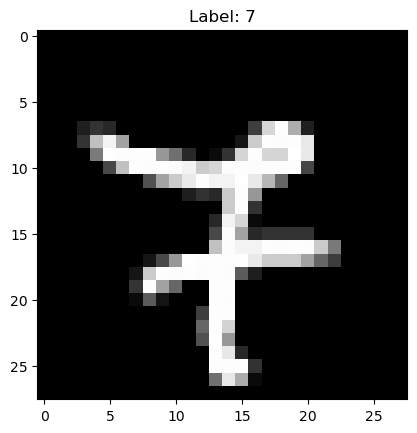

In [803]:
data_iter = iter(mnist_train_loader)
images, labels = next(data_iter)
image = images[0]
    
plot_image(image)

### Train

In [804]:
mnist_ae = Autoencoder(num_input_channels=1, base_channel_size=32, latent_dim=10, width=28, height=28)

# print("STEP 1: PRETRAIN AUTOENCODER")
print("TRAIN AUTOENCODER")
mnist_model, mnist_result = train_ae(
    train_loader=mnist_train_loader,
    val_loader=mnist_val_loader,
    latent_dim=10, 
    base_channel_size=32, 
    width=28, 
    height=28, 
    dataset_name='MNIST',
    feature_name='default'
)

WIDTH: 28
HEIGHT: 28
TRAIN AUTOENCODER
default


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


['default-10-32']
Best checkpoint (only one file): epoch=162-val_loss=80458.00.ckpt
FOUND PRETRAINED AUTOENCODER!
WIDTH: 28
HEIGHT: 28


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

### Check results

In [805]:
print(f"Final validation loss: {mnist_result['val'][0]['test_loss']}")

Final validation loss: 80458.0


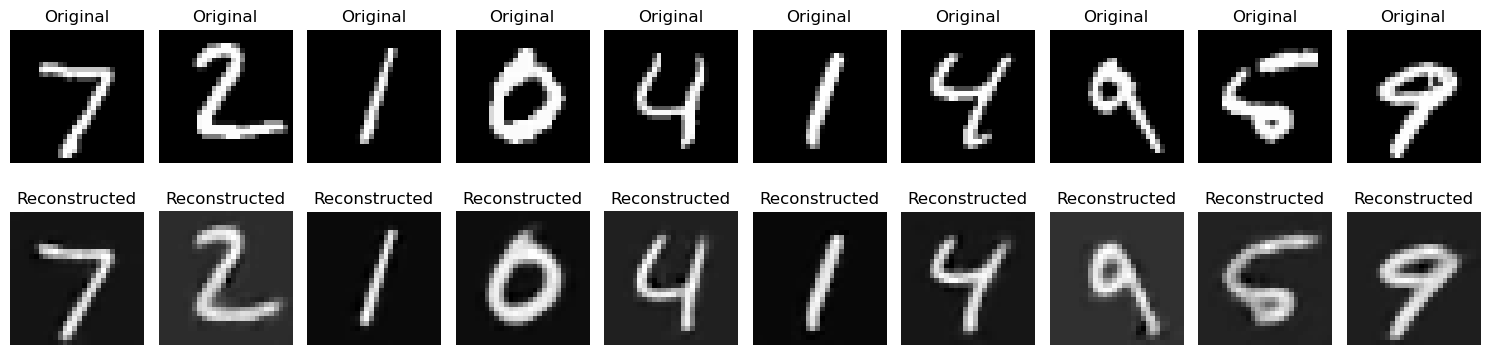

In [806]:
data_val_iter = iter(mnist_val_loader)
images, labels = next(data_val_iter)

# images = images.to(device)

# Pass images through the autoencoder
with torch.no_grad():
    reconstructed_images = mnist_model(images)

# Visualize original images and their reconstructions
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 4))

for idx in range(10):
    axes[0, idx].imshow(images[idx].squeeze().cpu(), cmap='gray')
    axes[0, idx].axis('off')
    axes[0, idx].set_title('Original')

    axes[1, idx].imshow(reconstructed_images[idx].squeeze().cpu(), cmap='gray')
    axes[1, idx].axis('off')
    axes[1, idx].set_title('Reconstructed')

plt.tight_layout()
plt.show()

### Cluster

In [807]:
embeddings, true_labels = get_embeddings(mnist_model, mnist_val_loader, device)
print(f"Shape of embeddings: {embeddings.shape}")
print(f"embeddings[0]: {embeddings[0]}")
print(f"labels: {true_labels}")

Shape of embeddings: (10000, 10)
embeddings[0]: [ 3.230724    2.4612515   0.4086955   1.0973748   0.55536     2.0794358
 -0.12201174  0.9728803   1.6761647   0.97066796]
labels: [7 2 1 ... 4 5 6]


In [808]:
# Number of clusters
num_clusters = 10

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto')
predicted_labels = kmeans.fit_predict(embeddings)

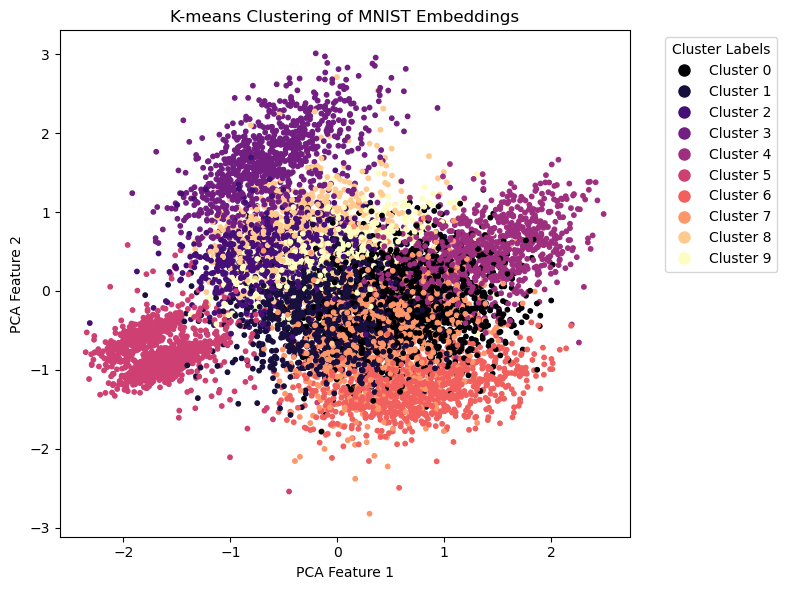

In [816]:
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Generate a color map
num_clusters = len(np.unique(predicted_labels))
cmap = plt.get_cmap('magma', num_clusters)

# Plotting the clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=predicted_labels, cmap=cmap, s=10)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i / (num_clusters - 1)), markersize=10, linestyle='') for i in range(num_clusters)]
labels = [f'Cluster {i}' for i in range(num_clusters)]
plt.legend(handles=handles, labels=labels, title='Cluster Labels', loc='best', bbox_to_anchor=(1.05, 1))

plt.title('K-means Clustering of MNIST Embeddings')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.tight_layout()
plt.show()

In [817]:
def compute_cluster_purity(true_labels, predicted_labels, num_true_clusters, num_predicted_clusters):
    purity_matrix = np.zeros((num_true_clusters, num_predicted_clusters))

    for i in range(num_predicted_clusters):
        cluster_indices = np.where(predicted_labels == i)[0]
        
        # Skip if there is no data points in cluster i
        if len(cluster_indices) == 0:
            continue
        
        cluster_true_labels = true_labels[cluster_indices]
        unique_true_labels, counts = np.unique(cluster_true_labels, return_counts=True)
        most_frequent_true_label = unique_true_labels[np.argmax(counts)]
        purity_matrix[most_frequent_true_label, i] = counts.max() / len(cluster_indices)

    return purity_matrix


def assign_clusters(true_labels, predicted_labels, num_true_clusters, num_predicted_clusters):
    purity_matrix = compute_cluster_purity(true_labels, predicted_labels, num_true_clusters, num_predicted_clusters)
    row_ind, col_ind = linear_sum_assignment(-purity_matrix)  # maximize the sum of purities

    cluster_mapping = {}
    for i, j in zip(row_ind, col_ind):
        cluster_mapping[j] = i

    return cluster_mapping


def map_clusters(predicted_labels, cluster_mapping):
    mapped_labels = np.zeros(len(predicted_labels))
    for predicted_cluster, true_cluster in cluster_mapping.items():
        mapped_labels[predicted_labels == predicted_cluster] = true_cluster
    return mapped_labels.astype(int)

In [818]:
cluster_mapping = assign_clusters(true_labels, predicted_labels, 10, 10)
mapped_labels = map_clusters(predicted_labels, cluster_mapping)

accuracy = accuracy_score(true_labels, mapped_labels)
print(f"Clustering Accuracy: {accuracy:.4f}")

nmi = normalized_mutual_info_score(true_labels, predicted_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

Clustering Accuracy: 0.7735
Normalized Mutual Information (NMI): 0.7564


### DCEC MNIST

In [61]:
# mnist_DCEC_model, mnist_DCEC_results = train_dcec(
#     autoencoder=mnist_model, 
#     n_clusters=10, 
#     train_loader=mnist_train_loader,
#     val_loader=mnist_val_loader,
#     dataset_name='MNIST',
#     feature_name='default'
# )

In [62]:
# print(f"Final validation loss: {mnist_DCEC_results['val'][0]['test_total_loss']}")

In [63]:
# def get_dcec_predictions(model, data_loader):
#     model.eval()
#     y_pred_list = []
#     model.to(device)
    
#     with torch.no_grad():
#         for batch in data_loader:
#             x, _ = batch
#             x = x.to(device)
#             _, _, q = model(x)
#             y_pred = torch.argmax(q, dim=1)
#             y_pred_list.append(y_pred)
            
#     model.train()
#     return torch.cat(y_pred_list)

In [64]:
# dcec_labels = mnist_DCEC_model._get_y_pred(mnist_val_loader).cpu().numpy()
# dcec_labels

In [65]:
# # dcec_labels = get_dcec_predictions(mnist_DCEC_model, mnist_val_loader).cpu().numpy()

# dcec_cluster_mapping = assign_clusters(true_labels, dcec_labels, 10, 10)
# dcec_mapped_labels = map_clusters(dcec_labels, dcec_cluster_mapping)

# dcec_accuracy = accuracy_score(true_labels, dcec_mapped_labels)
# print(f"Clustering Accuracy: {dcec_accuracy:.4f}")

# dcec_nmi = normalized_mutual_info_score(true_labels, dcec_labels)
# print(f"Normalized Mutual Information (NMI): {dcec_nmi:.4f}")

In [66]:
# set(dcec_labels)

In [69]:
# mnist_DCEC_model2, mnist_DCEC_results2 = train_dcec(
#     autoencoder=mnist_model, 
#     n_clusters=10, 
#     train_loader=mnist_train_loader,
#     val_loader=mnist_val_loader,
#     dataset_name='MNIST',
#     feature_name='default'
# )

In [68]:
# dcec_labels = get_dcec_predictions(mnist_DCEC_model2, mnist_val_loader).cpu().numpy()

# dcec_cluster_mapping = assign_clusters(true_labels, dcec_labels, 10, 10)
# dcec_mapped_labels = map_clusters(dcec_labels, dcec_cluster_mapping)

# dcec_accuracy = accuracy_score(true_labels, dcec_mapped_labels)
# print(f"Clustering Accuracy: {dcec_accuracy:.4f}")

# dcec_nmi = normalized_mutual_info_score(true_labels, dcec_labels)
# print(f"Normalized Mutual Information (NMI): {dcec_nmi:.4f}")

In [67]:
# mnist_DCEC_model2.clustering_layer.clusters

### Clustering Layer

In [30]:
# class ClusteringLayer(nn.Module):
#     def __init__(self, n_clusters, latent_dim, alpha):
#         super(ClusteringLayer, self).__init__()
#         self.n_clusers = n_clusters
#         self.alpha = alpha
        
#         self.clusters = nn.Parameter(torch.Tensor(n_clusters, latent_dim))
#         nn.init.xavier_uniform_(self.clusters)
        
#     def forward(self, z):
#         q = 1.0 / (1.0 + (torch.sum(torch.square(z.unsqueeze(1) - self.clusters), dim=2) / self.alpha))
#         q = q ** ((self.alpha + 1.0) / 2.0)
#         q = torch.transpose(torch.transpose(q, 0, 1) / torch.sum(q, dim=1), 0, 1)

#         return q
    
#     def set_clusters(self, cluster_centers):
#         self.clusters.data = torch.tensor(cluster_centers, dtype=torch.float32)

In [31]:
# def target_distribution(q):
#     weight = q ** 2 / q.sum(0)
#     return (weight.T / weight.sum(1)).T

### DCEC (Deep Convolutional Embedded Clustering)

In [32]:
# class DCEC(pl.LightningModule):
#     def __init__(self, n_clusters, autoencoder, latent_dim, data_loader, alpha=1.0, gamma=0.1, tol=1e-3):
#         super().__init__()
#         self.autoencoder = autoencoder
#         self.clustering_layer = ClusteringLayer(
#             n_clusters=n_clusters,
#             latent_dim=latent_dim,
#             alpha=alpha
#         )
#         self.data_loader = data_loader
        
#         self.y_pred = None
#         self.y_pred_last = None
#         self.delta_label = None
#         self.tol = tol
#         self.gamma=gamma
#         self.check_interval = 140
        
# #         self.criterion = nn.KLDivLoss(reduction='batchmean')
#         self.criterion = nn.KLDivLoss(reduction='sum')
#         self.save_hyperparameters(ignore=['autoencoder', 'data_loader'])
        
#     def forward(self, x):
#         encoded = self.autoencoder.encoder(x)
#         decoded = self.autoencoder.decoder(encoded)
#         clusters = self.clustering_layer(encoded)
        
#         return encoded, decoded, clusters
    
#     def configure_optimizers(self):
#         optimizer = optim.Adam(self.parameters(), lr=1e-3)

#         # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
#         scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#             optimizer,
#             mode="min",
#             factor=0.2,
#             patience=20,
#             min_lr=5e-5
#         )

#         return {
#             "optimizer": optimizer,
#             "lr_scheduler": scheduler,
#             "monitor": "val_total_loss"
#         }
    
#     def _get_loss(self, batch, step_type):
#         x, _ = batch # ignore labels
#         encoded, decoded, clusters = self(x)
        
#         # Compute reconstruction loss (autoencoder)
#         recon_loss = F.mse_loss(x, decoded, reduction="mean")
        
#         # Compute KL divergence loss (clustering layer)
#         q = clusters
#         p = target_distribution(q)
#         kl_loss = self.gamma * self.criterion(torch.log(q), p)
        
#         # Total loss
#         loss = recon_loss + kl_loss
    
#         # Logging
#         self.log(f'{step_type}_recon_loss', recon_loss)
#         self.log(f'{step_type}_kl_loss', kl_loss)
#         self.log(f'{step_type}_total_loss', loss)
        
#         return loss
    
#     def training_step(self, batch, batch_idx):
#         loss = self._get_loss(batch, "train")
#         return loss
    
#     def validation_step(self, batch, batch_idx):
#         self._get_loss(batch, "val")
        
#     def test_step(self, batch, batch_idx):
#         self._get_loss(batch, "test")
                  
#     def on_train_epoch_end(self):
#         if self.trainer.current_epoch == 0:
#             print("EPOCH 0, SET y_pred_last")
#             self.y_pred = self._get_y_pred(self.data_loader)
#             self.y_pred_last = self.y_pred.clone().detach()
        
#         if (self.trainer.current_epoch + 1) % self.check_interval == 0:
#             print(f"CHECK TOLERANCE THRESHOLD, EPOCH: {self.trainer.current_epoch}")
#             self.y_pred = self._get_y_pred(self.data_loader)

#             if self.y_pred_last is not None:
#                 self.delta_label = torch.sum(self.y_pred != self.y_pred_last).item()
#                 self.delta_label = self.delta_label / self.y_pred.shape[0]

#             self.y_pred_last = self.y_pred.clone().detach()

#             if self.current_epoch > 0 and self.delta_label < self.tol:
#                 print(f'Reached tolerance threshold. Stopping training. delta_label: {self.delta_label}, tol: {self.tol}')
#                 self.trainer.should_stop = True
            
#     def _get_y_pred(self, data_loader):
#         self.eval()
#         y_pred_list = []

#         with torch.no_grad():
#             for batch in data_loader:
#                 x, _ = batch
#                 x = x.to(device)
#                 _, _, q = self(x)
#                 y_pred = torch.argmax(q, dim=1)
#                 y_pred_list.append(y_pred)

#         self.train()
#         return torch.cat(y_pred_list)
            
#     @classmethod
#     def load_from_checkpoint(cls, checkpoint_path, autoencoder, n_clusters, latent_dim, data_loader, **kwargs):
#         checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
#         model = cls(n_clusters=n_clusters, autoencoder=autoencoder, latent_dim=latent_dim, data_loader=data_loader)
#         model.load_state_dict(checkpoint['state_dict'])
#         return model

#### Step 3: Deep clustering

In [136]:
# def train_dcec(autoencoder, n_clusters, train_loader, val_loader, dataset_name=DATASET_NAME, feature_name=FEATURE_NAME):
#     pretrained_dir = os.path.join(CHECKPOINT_PATH, dataset_name, "DCEC")
#     checkpoint_callback = get_model_checkpoint(pretrained_dir, "DCEC", f"{feature_name}-{autoencoder.latent_dim}-n_clu-{n_clusters}")
    
#     trainer = pl.Trainer(
#         default_root_dir=os.path.join('..', 'logs'),
#         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
#         devices=1,
#         max_epochs=EPOCHS_DCEC,
#         callbacks=[
#             checkpoint_callback,
# #             GenerateCallback(get_first_n_images(feature_dataset, 4), every_n_epochs=10),
#             LearningRateMonitor("epoch")
#         ]
#     )
    
#     trainer.logger._log_graph = True 
#     trainer.logger._default_hp_metric = None  
    
#     checkpoint_file = get_checkpoint_file(pretrained_dir, autoencoder.latent_dim, n_clusters, descriptor_feature=feature_name)
#     if os.path.isdir(pretrained_dir) and checkpoint_file is not None:
#         print("FOUND PRETRAINED DCEC!")
#         model = DCEC.load_from_checkpoint(
#             checkpoint_path=checkpoint_file, 
#             autoencoder=autoencoder, 
#             n_clusters=n_clusters, 
#             latent_dim=autoencoder.latent_dim,
#             data_loader=train_loader
#         )
#     else:
#         print("STEP 2: INIT CLUSTER CENTERS")
#         model = DCEC(
#             n_clusters=n_clusters, 
#             autoencoder=autoencoder, 
#             latent_dim=autoencoder.latent_dim,
#             data_loader=train_loader
#         )

#         kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=23, init='k-means++')

#         latent_representations, _ = get_embeddings(autoencoder, train_loader, device)
#         y_pred = kmeans.fit_predict(latent_representations)
#         cluster_centers = kmeans.cluster_centers_
#         model.clustering_layer.set_clusters(cluster_centers)
        
#         print("STEP 3: TRAIN DCEC")
#         trainer.fit(model, train_loader, val_loader)
    
#     val_result = trainer.test(model, val_loader, verbose=False)
#     result = {"val": val_result}
    
#     return model, result

In [1]:
# dcec_model_dict = {}

# for n_clusters in top_5_n_clusters:
#     print(f"STEP 2: INITIALIZE CLUSTER CENTER USING K-MEANS (N_CLUSTERS: {n_clusters})")
    
#     DCEC_model = DCEC(n_clusters=n_clusters, autoencoder=best_model, latent_dim=best_model.latent_dim)
#     autoencoder = DCEC_model.autoencoder 

#     latent_representations = []
#     with torch.no_grad():
#         for batch in train_loader:
#             x, _ = batch
#             z = autoencoder.encoder(x.to(autoencoder.device))
#             latent_representations.append(z.cpu().numpy())

#     latent_representations = np.concatenate(latent_representations, axis=0)        
#     kmeans = KMeans(n_clusters=n_clusters, n_init=23)
#     y_pred = kmeans.fit_predict(latent_representations)
#     cluster_centers = kmeans.cluster_centers_

#     DCEC_model.clustering_layer.set_clusters(cluster_centers)
    
#     print("STEP 3: TRAIN DCEC")
#     model_id, result_id = train_dcec(autoencoder, n_clusters)
#     dcec_model_dict[n_clusters] = {
#         "model": model_id,
#         "result": result_id
#     }

In [2]:
# for n_clusters in dcec_model_dict:
#     print(f"n_clusters: {n_clusters}")
#     print(dcec_model_dict[n_clusters]["result"])

In [3]:
# best_dcec_model, best_dcec_score = get_best_model(dcec_model_dict, 'test_total_loss')
        
# print(f"Best trained model: {best_model.latent_dim}, n_clusters: {best_dcec_model.clustering_layer.n_clusers}, loss: {best_dcec_score}")

### Tensorboard clustering

In [47]:
# writer = SummaryWriter('tensorboard/')

# img_embeds_len = len(train_img_embeds[0])

# writer.add_embedding(
#     train_img_embeds[1][:img_embeds_len],
#     metadata=[feature_dataset[i][1] for i in range(img_embeds_len)],
#     label_img=(train_img_embeds[0][:img_embeds_len] + 1) / 2.0
# )

In [48]:
# %tensorboard --logdir tensorboard/